In [94]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn import metrics
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report
from scipy.stats import uniform as sp_uniform
from sklearn.metrics import accuracy_score, f1_score, make_scorer, cohen_kappa_score
from lightgbm import LGBMClassifier
from sklearn.model_selection import learning_curve, ShuffleSplit

In [100]:
# Parse results data
results = pd.DataFrame()

for path in pathlib.Path('/Users/sam/Documents/projects/premier_league_predictions/data').rglob("*_fixtures.csv"):
    data = pd.read_csv(path)
    results = pd.concat([results, data])
    
# Remove missing values    
results = results.drop(['Unnamed: 0','away_ppg_home_team','home_ppg_away_team'], axis=1)
results = results.dropna(axis=0)
results = results[results.result.values != 'pp']
#results = results[~pd.isnull(results.result.values)]

In [101]:
results.shape

(6156, 13)

In [102]:
# Extract X, y values
X = results.iloc[:, :-1].values
y = results["result"].values

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Imput missing values
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(X_train)
X_train = imp.transform(X_train)
X_test = imp.transform(X_test)

In [103]:
y_values = []

for value in y:
    if value == "home":
        y_values.append(0)
    elif value == "away":
        y_values.append(1)
    else:
        y_values.append(2)
        
y = y_values

In [104]:
parameters={"early_stopping_rounds":20, 
            "eval_metric" : 'multi_logloss', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            'verbose': 100,
            'categorical_feature': 'auto'}

In [105]:
parameter_tuning ={
             'max_depth': sp_randint(1,5),
             'num_leaves': sp_randint(1, 5), 
             'learning_rate ': [1,0.1,0.01,0.001],
             'min_child_samples': sp_randint(20, 50), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [106]:
scorer = make_scorer(f1_score, average = 'weighted')

In [107]:
clf = LGBMClassifier(random_state=300, silent=True, metric='None', n_jobs=4, n_estimators=10000)

find_parameters = RandomizedSearchCV(
    estimator=clf, param_distributions=parameter_tuning, 
    n_iter=1000,
    scoring=scorer,
    cv=5,
    refit=True,
    random_state=300,
    verbose=False)

In [108]:
find_parameters.fit(X_train, y_train, **parameters)
print('Best score : {} with parameters: {} '.format(find_parameters.best_score_, find_parameters.best_params_))

Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 0.993876
Early stopping, best iteration is:
[105]	valid's multi_logloss: 0.993617


/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/_encode.py", line 183, in _encode
    diff = _check_unknown(values, uniques)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/_encode.py"

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/_encode.py", line 183, in _encode
    diff = _check_unknown(values, uniques)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/_encode.py"

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/_encode.py", line 183, in _encode
    diff = _check_unknown(values, uniques)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/_encode.py"

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/_encode.py", line 183, in _encode
    diff = _check_unknown(values, uniques)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/_encode.py"

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/_encode.py", line 183, in _encode
    diff = _check_unknown(values, uniques)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/_encode.py"

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/_encode.py", line 183, in _encode
    diff = _check_unknown(values, uniques)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/_encode.py"

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/_encode.py", line 183, in _encode
    diff = _check_unknown(values, uniques)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/_encode.py"

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/_encode.py", line 183, in _encode
    diff = _check_unknown(values, uniques)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/_encode.py"

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/_encode.py", line 183, in _encode
    diff = _check_unknown(values, uniques)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/_encode.py"

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/_encode.py", line 183, in _encode
    diff = _check_unknown(values, uniques)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/_encode.py"

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/_encode.py", line 183, in _encode
    diff = _check_unknown(values, uniques)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/_encode.py"

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/_encode.py", line 183, in _encode
    diff = _check_unknown(values, uniques)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/_encode.py"

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/_encode.py", line 183, in _encode
    diff = _check_unknown(values, uniques)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/_encode.py"

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/_encode.py", line 183, in _encode
    diff = _check_unknown(values, uniques)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/_encode.py"

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/_encode.py", line 183, in _encode
    diff = _check_unknown(values, uniques)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/_encode.py"

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/_encode.py", line 183, in _encode
    diff = _check_unknown(values, uniques)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/_encode.py"

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/_encode.py", line 183, in _encode
    diff = _check_unknown(values, uniques)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/_encode.py"

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/_encode.py", line 183, in _encode
    diff = _check_unknown(values, uniques)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/_encode.py"

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/_encode.py", line 183, in _encode
    diff = _check_unknown(values, uniques)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/_encode.py"

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/_encode.py", line 183, in _encode
    diff = _check_unknown(values, uniques)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/_encode.py"

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/_encode.py", line 183, in _encode
    diff = _check_unknown(values, uniques)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/_encode.py"

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py", line 793, in fit
    eval_set[i] = (valid_x, self._le.transform(valid_y))
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py", line 138, in transform
    return _encode(y, uniques=self.classes_)
  File "

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [109]:
best_parameters = find_parameters.best_params_
best_parameters

{'colsample_bytree': 0.6706735412200329,
 'learning_rate ': 0.1,
 'max_depth': 3,
 'min_child_samples': 30,
 'min_child_weight': 10.0,
 'num_leaves': 4,
 'reg_alpha': 50,
 'reg_lambda': 50,
 'subsample': 0.8256371463681569}

In [110]:
best_parameters_model = LGBMClassifier(**best_parameters)
best_parameters_model.set_params(**best_parameters)

LGBMClassifier(colsample_bytree=0.6706735412200329, learning_rate =0.1,
               max_depth=3, min_child_samples=30, min_child_weight=10.0,
               num_leaves=4, reg_alpha=50, reg_lambda=50,
               subsample=0.8256371463681569)

In [111]:
clf = best_parameters_model.fit(X_train, y_train)

In [112]:
y_preds = clf.predict(X_test)

In [113]:
np.mean(np.asarray(y_test) == y_preds)

0.5121753246753247

In [114]:
this_week = pd.read_csv("/Users/sam/Documents/projects/premier_league_predictions/current_gameweek.csv", index_col=0)

In [115]:
preds = []

this_week = this_week.drop(['away_ppg_home_team','home_ppg_away_team'], axis=1)

this_week = imp.transform(this_week)

for result in clf.predict(this_week):
    print(result)
    if result == 0:
        preds.append("home")
    elif result == 1:
        preds.append("away")
    else:
        preds.append("draw")
    
preds

home
home
home
away
home
away
home
home
away
home


['draw',
 'draw',
 'draw',
 'draw',
 'draw',
 'draw',
 'draw',
 'draw',
 'draw',
 'draw']

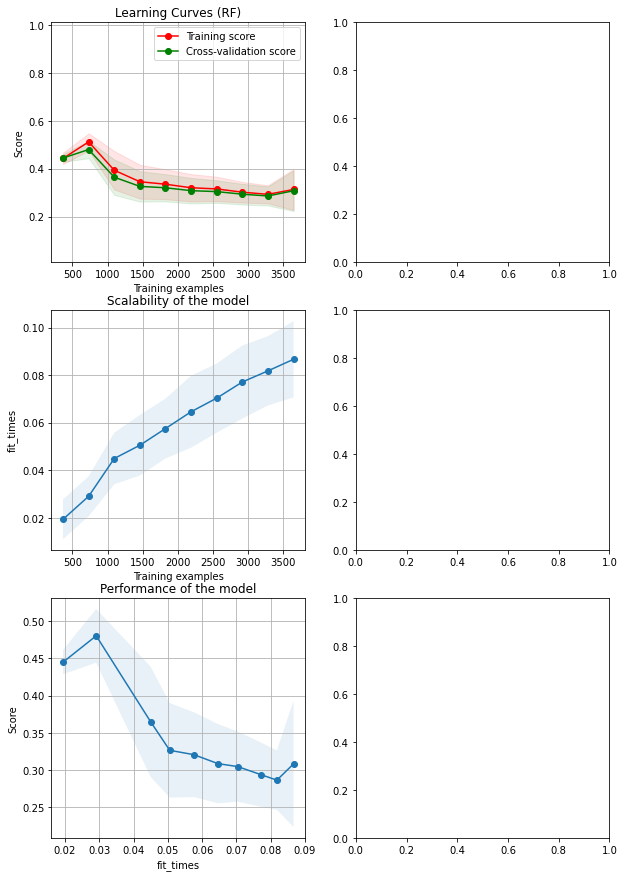

In [83]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 2, figsize=(10, 15))

title = "Learning Curves (RF)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
plot_learning_curve(clf, title, X, y, axes=axes[:, 0], ylim=(0.01, 1.01),
                    cv=cv, n_jobs=4)

plt.show()